Michael Ricardo DS 2500 Project Treasure Hunter

In [25]:
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
def fetch_ticker_data(ticker):
    """
    Fetches data yfinance library from yahoo finance given a start date in datetime format
    until the most recent market trading day. Normalizes timezones and removes timzone for simplicity.argmax

    Args: 
        ticker(str): Representing the offical company or instrument stock ticker, given ^ intially if an index
    Returns
        df (DataFrame): DataFrame with Instrument pricing data
    """
    
    most_recent = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
    start_date = '2014-12-01'
    
    stock_data = yf.Ticker(ticker)
    returning_data = stock_data.history(start = start_date, end= most_recent)
    
    returning_data.index = returning_data.index.tz_localize(None).normalize() #Timezone Normalization

    return returning_data

In [27]:
#Data for the IRX, Thirteen Year Treasury Bill
ticker = '^IRX'
Thirteen_Week = fetch_ticker_data(ticker)
Thirteen_Week = Thirteen_Week.drop(columns=['Open','Dividends', 'Stock Splits', 'Volume', 'High', 'Low'])
Thirteen_Week = Thirteen_Week.rename(columns={'Close': '13_week_close'})

In [28]:
#Data for the TNX, Ten Year Treasury Note 
ticker = '^TNX'
Ten_Year = fetch_ticker_data(ticker)
Ten_Year = Ten_Year.drop(columns=['Open','Dividends', 'Stock Splits', 'Volume'])
Ten_Year = Ten_Year.rename(columns={'High': '10_year_high', 'Low': '10_year_low', 'Close': '10_year_close'})

In [29]:
#Data for the BCOM, Bloomberg Commodity Index
ticker = '^BCOM'
Comm = fetch_ticker_data(ticker)
Comm['BCOM_SMA_14'] = ta.sma(Comm['Close'], length=14) 
Comm = Comm.drop(columns=['Open', 'High', 'Low', 'Dividends', 'Stock Splits', 'Volume', 'Close'])

In [30]:
#VIX Data, Chicago Board Options Exchange Volatility Index
ticker = '^VIX'
VIX = fetch_ticker_data(ticker)
VIX['VIX_SMA_14'] = ta.sma(VIX['Close'], length=14) 
VIX = VIX.drop(columns=['Open', 'High', 'Low', 'Dividends', 'Stock Splits', 'Volume', 'Close'])

Pulling external csv data, merge prep

In [31]:
#CPI data CSV, Consumer Price Index
cpi_csv = 'CPI_Data_10.csv'
cpi = pd.read_csv(cpi_csv)
cpi = cpi.rename(columns={'Close': 'CPI_close'})
cpi['Date'] = pd.to_datetime(cpi['Date'])
cpi = cpi.set_index('Date')

In [32]:
'''Fill CPI data as the monthly value present in every date time day.
    Creating new index and forward filling from the entry of 01 of each month.'''
full_date_range = pd.date_range(start='2014-12-01', end=datetime.today(), freq='D')
cpi = cpi.reindex(full_date_range)
cpi = cpi.ffill()
cpi.index.name = 'Date'

In [33]:
#One Year pulling in CSV, One Year treasury note 
one_year_csv = '1year_bond_master.csv'
One_Year = pd.read_csv(one_year_csv)

In [34]:
#Further cleaning needed for the 1 year, flipping the rows, stripping % sign to float
One_Year = One_Year.iloc[::-1] 
One_Year['Close'] = One_Year['Close'].str.rstrip('%').astype(float)
One_Year = One_Year.set_index('Date')

In [35]:
#Finding MACD and saving MACDs for evaluation 
one_year_MACD = ta.macd(One_Year["Close"], fast=12, slow=26, signal=9)
One_Year = pd.concat([One_Year, one_year_MACD], axis=1)


In [36]:
#Drop unwanted Cols
One_Year = One_Year.drop(columns=['Open', 'High', 'Low', 'Close', 'MACD_12_26_9','MACDh_12_26_9'])

Finding Short Term Spread and Yield Standerd Deviation

In [37]:
#Yield STDEV
Ten_Year['Yield_STDEV'] = ta.stdev(Ten_Year['10_year_close'], length = 14)

In [38]:
#Finding 10 year & thirteen week credit spread 
Ten_Year['Short_Term_Spread'] = Ten_Year['10_year_close'] - Thirteen_Week['13_week_close']

Ten_Year = Ten_Year.drop(columns=['10_year_low', '10_year_high'])

Combing existing Data frames

In [39]:

def combine(df_first, dfs):
    """
    Combining the data from multiple dataframes to df_first. Created same datetime object
    Args:
        df_main (dataframe): Main instrument set to have other cols added
        df_s (list): list of dataframes concated to df_main
    Returns:
        df_first: Concated df of df_first and dfs
    """
    for df in dfs:
        df.index = pd.to_datetime(df.index)
        df_first = pd.concat([df_first, df], axis=1)
    return df_first

In [40]:
#Merging dfs drop NA
dfs = [VIX, One_Year, cpi, Comm]
df_first = Ten_Year
final_df = combine(df_first, dfs).dropna()
final_df

,10_year_close,Yield_STDEV,Short_Term_Spread,VIX_SMA_14,MACDs_12_26_9,CPI_close,BCOM_SMA_14
Date,,,,,,,
2015-01-20,1.807,0.134184,1.799,19.477857,0.012013,234.747,103.221429
2015-01-21,1.853,0.119475,1.833,19.687143,0.008745,234.747,102.967858
2015-01-22,1.896,0.099177,1.881,19.487143,0.005734,234.747,102.772143
2015-01-23,1.817,0.082887,1.804,19.406428,0.003029,234.747,102.577143
2015-01-26,1.828,0.073557,1.823,19.092143,0.000650,234.747,102.354286
...,...,...,...,...,...,...,...
2024-11-20,4.406,0.056236,-0.004,16.714286,0.038259,315.454,97.752857
2024-11-21,4.432,0.057928,0.019,16.356429,0.039220,315.454,97.812857
2024-11-22,4.410,0.054405,-0.005,15.875000,0.040553,315.454,97.817142


In [41]:
#evaluting correlation of elements
matrix = final_df.corr()

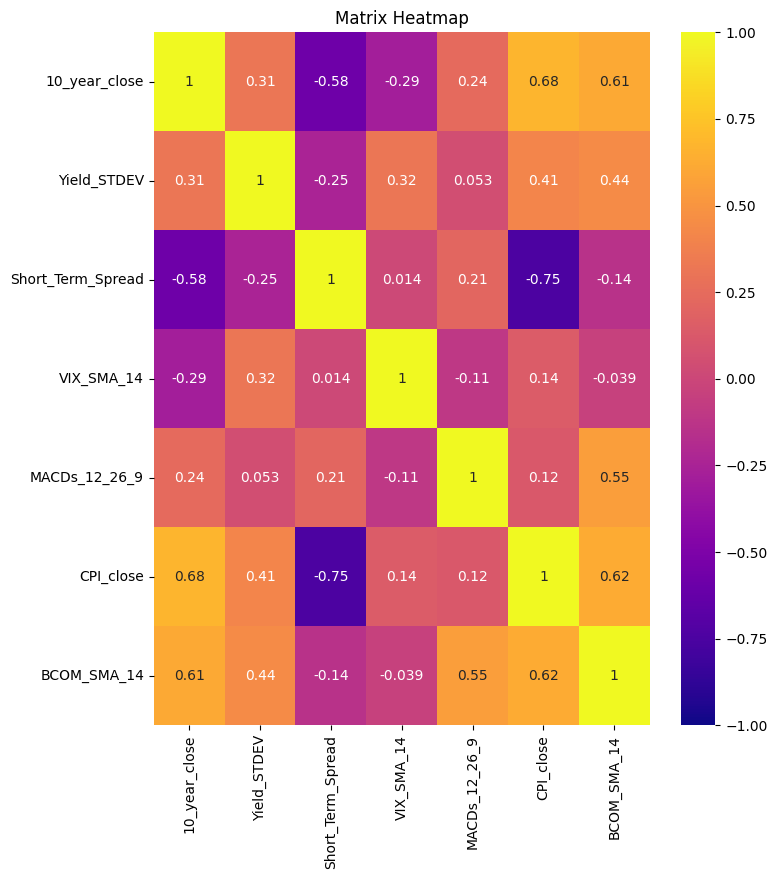

In [42]:
# Visualization: Multicollinearity with Heatmap
plt.figure(figsize=(8, 9))
sns.heatmap(matrix,annot = True, cmap="plasma", vmin=-1, vmax=1)
plt.title("Matrix Heatmap")
plt.show()

In [43]:
#Adding a year column for visuliztion 
final_df['year'] = final_df.index.year

In [44]:
#Standerdization using X - Mean / STD formula
X_work = ['Yield_STDEV','Short_Term_Spread'	,'VIX_SMA_14','MACDs_12_26_9','CPI_close','BCOM_SMA_14']
for col in X_work:
    final_df[col] = (final_df[col] - final_df[col].mean()) / final_df[col].std()
X = final_df[['Yield_STDEV','Short_Term_Spread'	,'VIX_SMA_14','MACDs_12_26_9','CPI_close','BCOM_SMA_14']]
y = final_df['10_year_close']

Regressions:

In [45]:
def linreg_predict(X, y):
    """Predicts y vals for a given df or array using skylearn linear_regression_model
    Args:
        X (dataframe): 1 or multiple df converting into 2d array as independent variables
        y (dataframe): 1 df or 1d array as dependent variables
    Returns:
        dct(dictionary): Containing ypreds, resids, rmse, r2, MAE, coef, intercept
    """
    
    linear_regression_model = LinearRegression()
    linear_regression_model.fit(X, y)
    
    dct = {}

    dct["ypreds"] = linear_regression_model.predict(X)
    dct["resids"] = y - dct["ypreds"]
    dct["rmse"] = np.sqrt(((dct["ypreds"] - y) ** 2).mean())
    dct["r2"] = r2_score(y, dct["ypreds"])
    dct['MAE'] = mean_absolute_error(y, dct["ypreds"])
    dct['coef'] = linear_regression_model.coef_
    dct['intercept'] = linear_regression_model.intercept_

    return dct

In [46]:
#Doing Cross-Fold validation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25, test_size = 0.3)
linear_reg_output_cross_fold = linreg_predict(X_train,y_train)
linear_reg_output_cross_fold

{'ypreds': array([3.79509413, 2.59205332, 2.50784667, ..., 3.59767814, 1.83702703,
        2.38739791]),
 'resids': Date
 2024-01-16    0.270906
 2021-11-10   -1.032053
 2019-04-08    0.011153
 2017-12-29   -0.039742
 2015-08-27    0.606228
                 ...   
 2019-09-30   -0.893293
 2016-01-27    0.920880
 2023-10-24    1.242322
 2016-04-27    0.022973
 2019-09-03   -0.921398
 Name: 10_year_close, Length: 1724, dtype: float64,
 'rmse': 0.5769704451868318,
 'r2': 0.6930714101357589,
 'MAE': 0.4836320922028509,
 'coef': array([ 0.07519389, -0.47609159, -0.301469  ,  0.07019404,  0.08138314,
         0.42946628]),
 'intercept': 2.466160774806685}

In [ ]:
#Declaration for plots
residuals = linear_reg_output_cross_fold['resids']
predictions = linear_reg_output_cross_fold['ypreds']
coefs = linear_reg_output_cross_fold['coef']

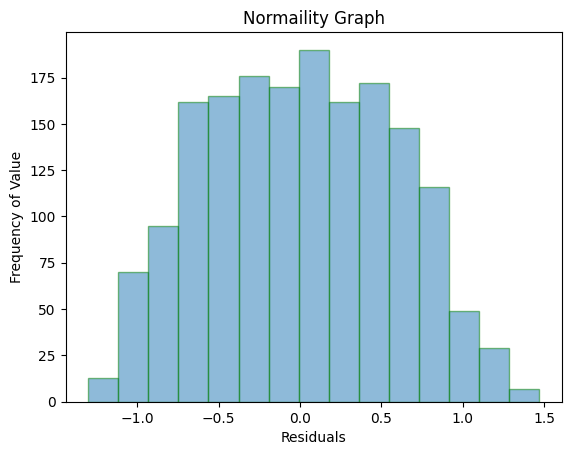

In [48]:
#Visualization: Noramility
plt.hist(residuals, bins=15, edgecolor='Green', alpha=0.5)
plt.title("Normaility Graph")
plt.xlabel("Residuals")
plt.ylabel("Frequency of Value")
plt.show()

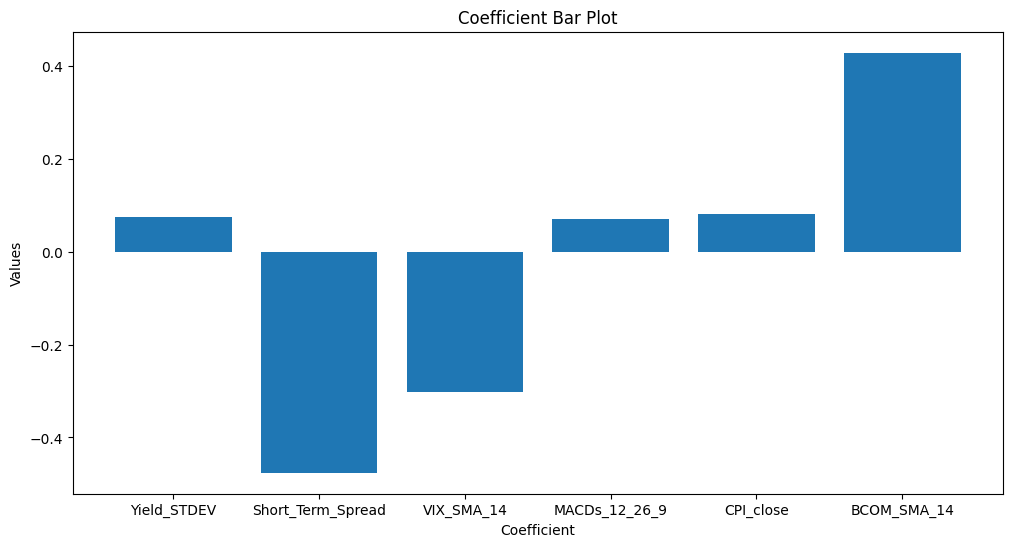

In [49]:
#Visualization: Varibale importance 
plt.figure(figsize=(12, 6))
plt.bar(X_work, coefs)
plt.title('Coefficient Bar Plot')
plt.xlabel('Coefficient')
plt.ylabel('Values')
plt.show()

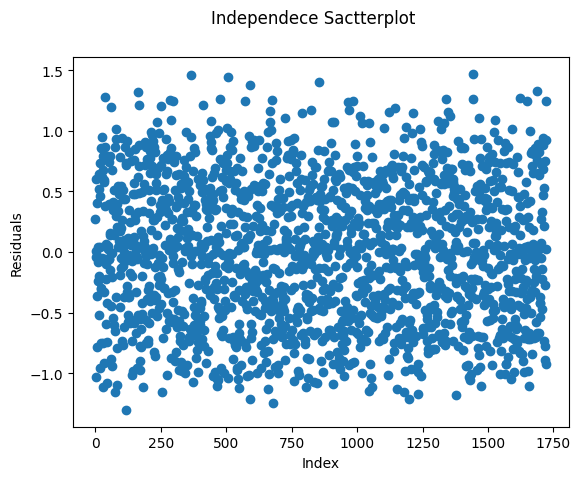

In [ ]:
#Visualization: Independece graph
plt.scatter(range(len(residuals)), residuals)
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.suptitle('Independece Sactterplot')
plt.show()

Performing regression on entire dataset to analyze variabel-prediction perfromance

In [ ]:
#Regressing on entire dataset for analysis upon individual forces
linear_reg_output = linreg_predict(X,y)
resids = linear_reg_output['resids']
ypreds = linear_reg_output['ypreds']
y = np.array(y)

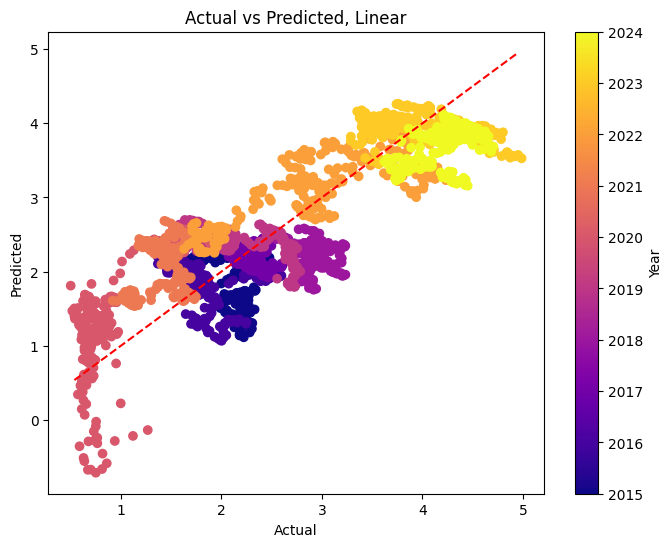

In [52]:
# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plot = plt.scatter(y, ypreds, c=final_df['year'],cmap='plasma')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.colorbar(plot, label='Year')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted, Linear')
plt.show()

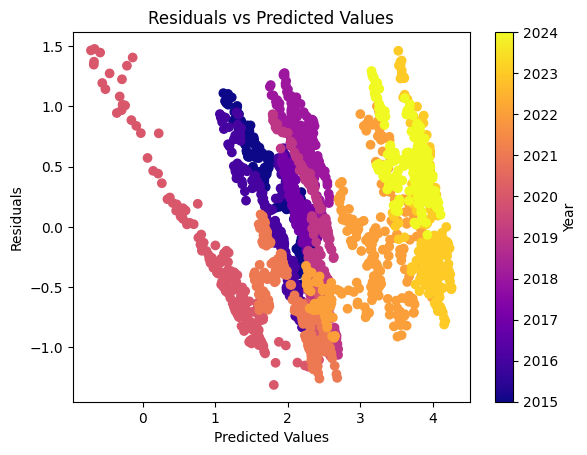

In [53]:
# Residual plot
plot = plt.scatter(ypreds, resids, c=final_df['year'],cmap='plasma')
plt.colorbar(plot, label='Year')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

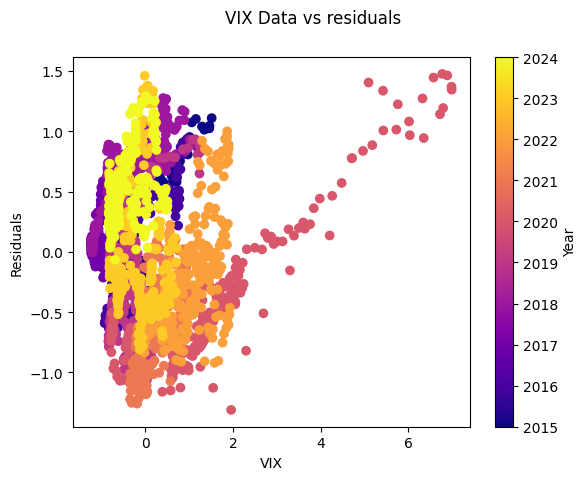

In [54]:
#VIX Data vs resids 
plot = plt.scatter(final_df['VIX_SMA_14'], resids, c=final_df['year'], cmap='plasma')
plt.colorbar(plot, label='Year')
plt.xlabel('VIX')
plt.ylabel('Residuals')
plt.suptitle('VIX Data vs residuals')
plt.show()

/tmp/ipykernel_20927/2048392568.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


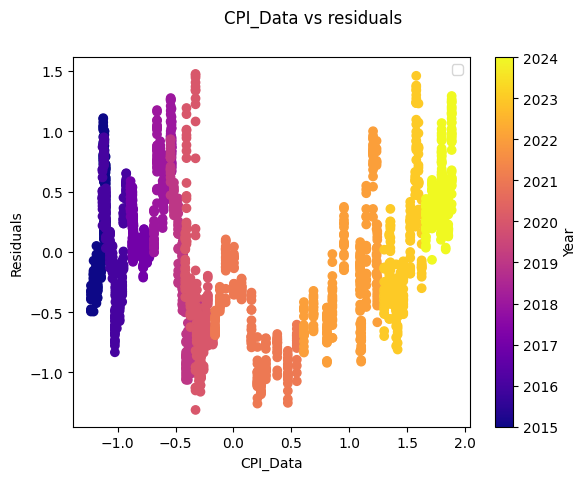

In [55]:
#CPI vs resids 
plot = plt.scatter(final_df['CPI_close'], resids, c=final_df['year'], cmap='plasma')
plt.colorbar(plot, label='Year')
plt.xlabel('CPI_Data')
plt.ylabel('Residuals')
plt.suptitle('CPI_Data vs residuals')
plt.legend()
plt.show()

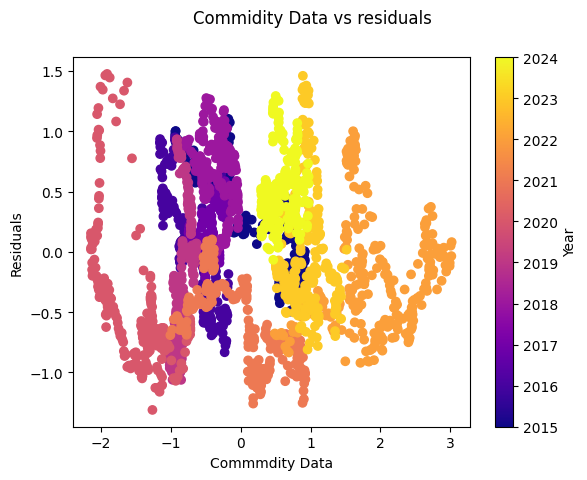

In [56]:
#Commodities vs resids 
plot = plt.scatter(final_df['BCOM_SMA_14'], resids, c=final_df['year'], cmap='plasma')
plt.colorbar(plot, label='Year')
plt.xlabel('Commmdity Data')
plt.ylabel('Residuals')
plt.suptitle('Commidity Data vs residuals')
plt.show()

In [57]:
from sklearn.preprocessing import PolynomialFeatures

#Perfomring Polynomeial regression 
poly_fit = PolynomialFeatures(degree = 4, include_bias = False)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X, y, random_state=25, test_size = 0.3)
X_poly = poly_fit.fit_transform(X_train_poly)
multiple_reg = linreg_predict(X_poly,y_train_poly)
ypreds = multiple_reg['ypreds']
resids = multiple_reg['resids']
multiple_reg

{'ypreds': array([4.10954201, 1.63173107, 2.52612918, ..., 4.67085739, 1.69740525,
        1.54322879]),
 'resids': array([-0.04354202, -0.07173113, -0.00712913, ...,  0.16914277,
         0.16259476, -0.07722883]),
 'rmse': 0.10167439622153374,
 'r2': 0.9904686720343724,
 'MAE': 0.07775706313418485,
 'coef': array([ 3.28003747e-02, -1.05634956e+00, -6.19373029e-01,  8.61869885e-01,
        -2.68661368e+00,  8.37229499e-01,  2.23935386e-02,  1.97186776e-01,
        -1.76683252e-01,  5.19984703e-02,  5.23133513e-01, -2.64659356e-01,
         2.42817019e-03,  7.99714838e-01,  1.73967320e-01,  1.22460241e+00,
        -8.05830264e-01, -1.87535619e-01, -8.34795245e-02, -8.50485068e-01,
        -1.29475135e-02,  1.49024899e-01, -7.69177868e-02, -3.20364590e-01,
         1.50877248e+00,  4.01534151e-01, -3.33198601e-01,  2.70146285e-02,
         5.36640573e-02, -3.64881861e-02,  1.77129451e-02,  1.14327779e-01,
        -8.96979721e-02, -2.06145934e-01,  3.11190381e-02,  2.64610897e-01,
      

In [58]:
#Also plotting to recieve he non-training R squared in evaulting fitting
X_poly_test = poly_fit.fit_transform(X_test_poly)
multiple_reg = linreg_predict(X_test_poly, y_test)
multiple_reg

{'ypreds': array([ 2.00436912,  2.26640631,  1.88747249,  2.27190947,  1.8204878 ,
         1.40788281,  1.85967151,  2.25083157,  2.02461133,  1.93045922,
         2.20702173,  3.94406412,  2.31881889,  2.3590695 ,  2.24600281,
         1.88822449,  0.01268597,  2.17492992,  3.9863576 ,  2.55633035,
         2.35005123,  2.5692917 ,  2.33313939,  2.55588748,  2.81439346,
         2.23193068,  1.51828577,  2.09800016,  4.24610799,  2.43472326,
         3.97663371,  2.03282692,  3.9360752 ,  2.33755409,  1.51019428,
         1.63851106,  1.10936012,  2.28162468,  2.1905986 ,  2.66690502,
         2.27500542,  2.53967598,  1.68007997,  3.6090671 ,  2.07170298,
         1.58772   ,  2.02262592,  2.55513751,  2.89844303,  3.78751665,
         1.91138183,  1.91006745,  2.20280231,  2.44518104,  3.86855691,
         2.08829532,  2.36738439,  2.0596533 ,  3.79135677,  2.33127336,
         2.31826252,  3.9535451 ,  2.08266456,  2.22478612,  1.67764325,
         1.9962638 ,  2.60204773,  3.5640

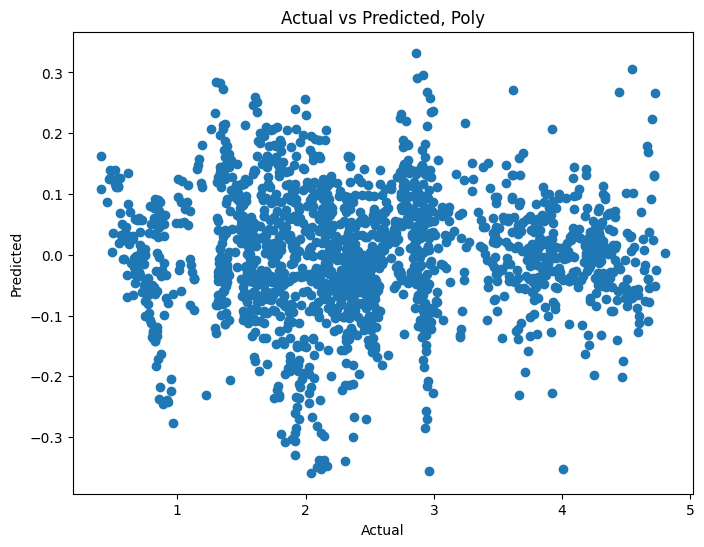

In [59]:
# Visualization: Actual vs Predicted: Polynomial

plt.figure(figsize=(8, 6))
plt.scatter(ypreds, resids)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted, Poly')
plt.show()

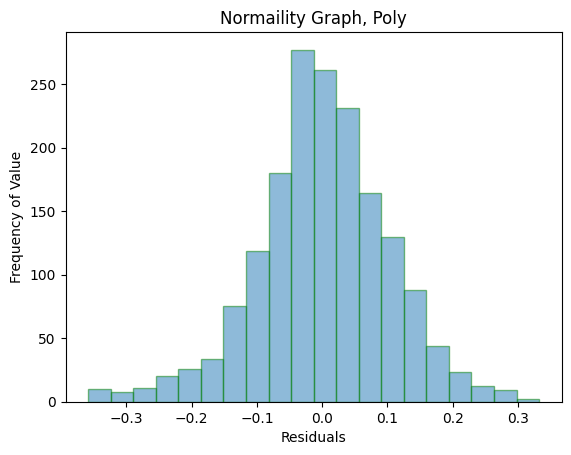

In [60]:
#Plot 3 Poly, Normaility
plt.hist(resids, bins=20, edgecolor='Green', alpha=0.5)
plt.title("Normaility Graph, Poly")
plt.xlabel("Residuals")
plt.ylabel("Frequency of Value")
plt.show()

#Source for MACD
https://tradingstrategy.ai/docs/api/technical-analysis/momentum/help/pandas_ta.momentum.macd.html

#Data source for One-Year Treasury
https://www.marketwatch.com/investing/bond/tmubmusd01y/download-data?countrycode=bx&mod=mw_quote_tab 

#Yfinance
https://pypi.org/project/yfinance/

#CPI
https://fred.stlouisfed.org/series/CPIAUCSL